# PRUEBA 1: EVALUACIÓN INTEGRAL DE TECNOLOGÍAS SOLAR    "PV vs CSP"

**Alumna: Nicole Torres**

**Profesor: Cristobal Parrado**

<u>Introducción</u>
<p style="text-align: justify;">
El objetivo de este trabajo consiste en realizar un análisis comparativo entre las tecnologías solar fotovoltaica (PV) y de concentración (CSP), utilizando ciencia de datos e inteligencia artificial. Para esto, mediante el desarrollo de distintos códigos de programación, se realizaran simulaciones de plantas pv y csp de distintas capacidades y en distintas partes del mundo, realizando estudios de sensibilidad con el fin de evaluar los distintos niveles de generación electrica, costo nivelado de la energía, factores de planta, etc.
</p>

<u>Estructura y descripción del proyecto:</u>
<p style="text-align: justify;">
Para cada simulación se considerarán los países de Chile, España y Australia, obteniendo su recurso solar a través de la plataforma de NREL, con un TMY en formato ".csv".
Cada código será desarrollado en un notebook, los cuales se dividirán en:
</p>

1.  `01_Analisis_Recurso_Solar` (Procesamiento del archivo TMY en formato .csv)
2.  `02_Simulacion_PV` (Define y ejecuta cada función que permite simular una planta PV)
3.  `03_Simulacion_csp` (Define y ejecuta cada función que permite simular una planta CSP)
4.  `04_Comparación_PV_CSP` (Realiza y Describe las comparaciones entre plantas)

<u>Resultados</u>
<p style="text-align: justify;">
Los resultados de cada simulación serán representados de dos formas: Como archivo formato .csv, los cuales serán guardados en la carpeta "Resultados", así como de forma gráfica, los cuales serán guardados en la carpeta "graficos".
</p>

<u>Visualización</u>
<p style="text-align: justify;">
Se desarrolla una plataforma de visualización interactiva. Para acceder, ingresar en el siguiente link:
</p>

<!-- Aquí puedes añadir el link -->

------------------------------------------------------------------------------------------------

In [7]:
# ----------- Función de Análisis de Recurso Solar --------------
"""
PARAMETROS INICIALES:
Script para analizar archivos CSV de recurso solar (GHI, DHI, DNI)
para diferentes ubicaciones y generar gráficos resumen.
Lee archivos desde la carpeta ../Datos y guarda resultados en ../Resultados_Recurso_Solar.
"""
import polars as pl
import matplotlib.pyplot as plt
import os
import traceback # Para imprimir errores detallados
import pandas as pd
import seaborn as sns
from IPython.display import display # Importar display si no está ya importado

# --- Definición de Rutas y Ubicaciones ---

# Obtener el directorio del script de forma segura
try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Si __file__ no está definido (ej. ejecución interactiva no estándar), usar CWD
    script_dir = os.getcwd()

# Asumiendo que este script está en PRUEBA1
datos_dir = os.path.abspath(os.path.join(script_dir, "Datos"))
# Directorio base para guardar resultados (se creará si no existe)
resultados_dir_base = os.path.abspath(os.path.join(script_dir, "graficos/recurso_solar"))
os.makedirs(resultados_dir_base, exist_ok=True)

print(f"Directorio del Script: {script_dir}")
print(f"Directorio de Datos: {datos_dir}")
print(f"Directorio Base de Resultados: {resultados_dir_base}")


# Definir las ubicaciones y sus archivos de datos únicos de la carpeta Datos
# Ahora solo especificamos el archivo, los metadatos se leerán del CSV.
ubicaciones = {
    'Chile': {
        'archivo': os.path.join(datos_dir, 'chile.csv') # Usar el original
    },
    'Espana': {
        'archivo': os.path.join(datos_dir, 'espana.csv')
    },
    'Australia': {
        'archivo': os.path.join(datos_dir, 'australia.csv')
    }
    # Antofagasta excluida
}

Directorio del Script: /home/nicole/UA/NicoleTorres/PRUEBA1
Directorio de Datos: /home/nicole/UA/NicoleTorres/PRUEBA1/Datos
Directorio Base de Resultados: /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/recurso_solar


In [8]:
# ---------- Funciones de Análisis y Gráficos --------------

def analizar_estadisticas(df):
    """Calcula estadísticas descriptivas para columnas numéricas clave."""
    columnas_numericas = ['GHI', 'DHI', 'DNI', 'Temperature', 'Wind Speed']
    # Filtrar para incluir solo columnas numéricas que existen en el df
    columnas_a_describir = [col for col in columnas_numericas if col in df.columns and df[col].dtype in pl.NUMERIC_DTYPES]
    
    if not columnas_a_describir:
        print("  Advertencia: No se encontraron columnas numéricas adecuadas para estadísticas descriptivas.")
        return None
        
    print("  Calculando estadísticas descriptivas...")
    try:
        # Usar describe() para obtener estadísticas básicas
        stats_df = df.select(columnas_a_describir).describe(
             percentiles=[0.25, 0.5, 0.75]
        )
        return stats_df
    except Exception as e:
        print(f"  Error calculando estadísticas descriptivas: {e}")
        return None

def detectar_outliers_iqr(df, columna, factor_iqr=1.5):
    """Detecta outliers en una columna usando el método IQR."""
    if columna not in df.columns or df[columna].dtype not in pl.NUMERIC_DTYPES:
        return 0, 0, 0, None, None # Devolver ceros y None si la columna no es válida
        
    try:
        q1 = df[columna].quantile(0.25)
        q3 = df[columna].quantile(0.75)
        iqr = q3 - q1
        
        if iqr is None or q1 is None or q3 is None:
             print(f"  Advertencia: No se pudo calcular IQR para {columna} (posiblemente todos los valores son iguales o nulos).")
             return 0, 0, 0, None, None

        limite_inferior = q1 - factor_iqr * iqr
        limite_superior = q3 + factor_iqr * iqr
        
        # Contar outliers
        outliers_df = df.filter(
            (pl.col(columna) < limite_inferior) | (pl.col(columna) > limite_superior)
        )
        count_outliers = outliers_df.height
        
        # Calcular porcentaje
        total_validos = df[columna].is_not_null().sum()
        if total_validos > 0:
            porcentaje_outliers = (count_outliers / total_validos) * 100
        else:
            porcentaje_outliers = 0.0
            
        return count_outliers, porcentaje_outliers, total_validos, limite_inferior, limite_superior
        
    except Exception as e:
        print(f"  Error detectando outliers para {columna}: {e}")
        return 0, 0, df[columna].is_not_null().sum(), None, None # Devolver ceros pero intentar contar válidos

def resumen_outliers(df):
    """Genera un resumen de outliers para columnas numéricas clave."""
    print("  Detectando outliers (método IQR)...")
    columnas_numericas = ['GHI', 'DHI', 'DNI', 'Temperature', 'Wind Speed']
    resumen = {}
    for col in columnas_numericas:
        if col in df.columns:
             count, percent, total_validos, lim_inf, lim_sup = detectar_outliers_iqr(df, col)
             if total_validos > 0: # Solo reportar si hubo datos válidos para analizar
                 resumen[col] = {
                     'count': count,
                     'percentage': percent,
                     'lower_bound': lim_inf,
                     'upper_bound': lim_sup,
                     'total_valid': total_validos
                 }
             else:
                  print(f"  Columna {col} no tenía datos válidos para análisis de outliers.")
        else:
             print(f"  Advertencia: Columna {col} no encontrada para análisis de outliers.")
             
    return resumen

def analizar_irradiacion_anual(df):
    """Analiza la irradiación anual por tipo"""
    resultados = {}
    for col_name in ['GHI', 'DHI', 'DNI']:
        if col_name in df.columns:
            try:
                df_col = df.select(pl.col(col_name).cast(pl.Float64, strict=False).fill_null(0.0))
                resultados[col_name] = {
                    'promedio': float(df_col.mean()[0,0] or 0.0),
                    'maximo': float(df_col.max()[0,0] or 0.0),
                    'minimo': float(df_col.min()[0,0] or 0.0),
                    'total': float(df_col.sum()[0,0] or 0.0)
                }
            except Exception as e:
                print(f"  Error al procesar columna anual {col_name}: {e}")
                resultados[col_name] = {'promedio': 0.0, 'maximo': 0.0, 'minimo': 0.0, 'total': 0.0}
        else:
            print(f"  Advertencia: Columna {col_name} no encontrada para análisis anual.")
            resultados[col_name] = {'promedio': 0.0, 'maximo': 0.0, 'minimo': 0.0, 'total': 0.0}
    return resultados

def analizar_irradiacion_mensual(df):
    """Analiza la irradiación mensual"""
    if 'Month' not in df.columns:
        print("  Error: Columna 'Month' no encontrada para análisis mensual.")
        return pl.DataFrame()

    agg_exprs = []
    columnas_irradiacion = ['GHI', 'DHI', 'DNI']
    columnas_presentes = [col for col in columnas_irradiacion if col in df.columns]

    if not columnas_presentes:
         print("  Error: No hay columnas de irradiación (GHI, DHI, DNI) disponibles para análisis mensual.")
         return pl.DataFrame()

    for col_name in columnas_presentes:
        agg_exprs.append(pl.col(col_name).cast(pl.Float64, strict=False).fill_null(0.0).mean().alias(f'{col_name}_promedio'))

    try:
        mensual = df.group_by('Month').agg(agg_exprs).sort('Month')
        meses_completos = pl.DataFrame({'Month': range(1, 13)})
        mensual_completo = meses_completos.join(mensual, on='Month', how='left').fill_null(0.0)
    except Exception as e:
        print(f"  Error durante la agregación mensual: {e}")
        return pl.DataFrame()

    return mensual_completo

def crear_graficos(df, resultados_dir_ubicacion, resultados_anuales, resultados_mensuales, ubicacion):
    """Crea los gráficos de análisis para una ubicación específica"""
    os.makedirs(resultados_dir_ubicacion, exist_ok=True)
    print(f"  Guardando gráficos para {ubicacion} en '{resultados_dir_ubicacion}'.")

    # --- Gráfico Mensual ---
    if not resultados_mensuales.is_empty() and resultados_mensuales.height == 12:
        plt.figure(figsize=(12, 6))
        meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
        plot_legend_mensual = False
        if 'GHI_promedio' in resultados_mensuales.columns and resultados_mensuales['GHI_promedio'].sum() > 0:
            plt.plot(meses, resultados_mensuales['GHI_promedio'], label='GHI', marker='o')
            plot_legend_mensual = True
        if 'DHI_promedio' in resultados_mensuales.columns and resultados_mensuales['DHI_promedio'].sum() > 0:
             plt.plot(meses, resultados_mensuales['DHI_promedio'], label='DHI', marker='s')
             plot_legend_mensual = True
        if 'DNI_promedio' in resultados_mensuales.columns and resultados_mensuales['DNI_promedio'].sum() > 0:
            plt.plot(meses, resultados_mensuales['DNI_promedio'], label='DNI', marker='^')
            plot_legend_mensual = True

        plt.xlabel('Mes')
        plt.ylabel('Irradiancia Promedio (W/m²)')
        plt.title(f'Irradiancia Promedio Mensual en {ubicacion}')
        if plot_legend_mensual:
             plt.legend()
        else:
             plt.text(0.5, 0.5, 'No hay datos de irradiación válidos para mostrar',
                      horizontalalignment='center', verticalalignment='center',
                      transform=plt.gca().transAxes, fontsize=12, color='red')
        plt.grid(True)
        plt.tight_layout()
        try:
            plt.savefig(os.path.join(resultados_dir_ubicacion, f'irradiacion_mensual_{ubicacion}.png'))
            print(f"    Gráfico mensual guardado.")
        except Exception as e:
            print(f"    Error al guardar gráfico mensual: {e}")
        plt.close()
    else:
        print(f"  No se generó gráfico mensual para {ubicacion} (datos mensuales vacíos o incompletos: {resultados_mensuales.height} filas).")

    # --- Gráfico Horario ---
    if 'Hour' not in df.columns:
        print(f"  Advertencia: Columna 'Hour' no encontrada. No se puede generar gráfico horario para {ubicacion}.")
        return

    agg_exprs_horaria = []
    columnas_irradiacion = ['GHI', 'DHI', 'DNI']
    columnas_presentes_hr = [col for col in columnas_irradiacion if col in df.columns]

    if not columnas_presentes_hr:
        print(f"  Advertencia: No hay columnas de irradiación para gráfico horario de {ubicacion}.")
        return

    for col_name in columnas_presentes_hr:
        agg_exprs_horaria.append(pl.col(col_name).cast(pl.Float64, strict=False).fill_null(0.0).mean().alias(f'{col_name}_promedio'))

    try:
        horaria = df.group_by('Hour').agg(agg_exprs_horaria).sort('Hour')

        if not horaria.is_empty():
            plt.figure(figsize=(12, 6))
            horas = range(24)
            horas_df = pl.DataFrame({'Hour': range(24)})
            horaria_completa = horas_df.join(horaria, on='Hour', how='left').fill_null(0.0)

            plot_legend_horaria = False
            if 'GHI_promedio' in horaria_completa.columns and horaria_completa['GHI_promedio'].sum() > 0:
                plt.plot(horas, horaria_completa['GHI_promedio'], label='GHI', marker='o')
                plot_legend_horaria = True
            if 'DHI_promedio' in horaria_completa.columns and horaria_completa['DHI_promedio'].sum() > 0:
                 plt.plot(horas, horaria_completa['DHI_promedio'], label='DHI', marker='s')
                 plot_legend_horaria = True
            if 'DNI_promedio' in horaria_completa.columns and horaria_completa['DNI_promedio'].sum() > 0:
                plt.plot(horas, horaria_completa['DNI_promedio'], label='DNI', marker='^')
                plot_legend_horaria = True

            plt.xticks(range(0, 24, 1))
            plt.gca().set_xticklabels([f'{h:02d}:00' for h in range(24)])
            plt.xlabel('Hora del día (24h)')
            plt.ylabel('Irradiancia Promedio (W/m²)')
            plt.title(f'Distribución Horaria de la Irradiancia en {ubicacion}')
            if plot_legend_horaria:
                plt.legend()
            else:
                 plt.text(0.5, 0.5, 'No hay datos de irradiación válidos para mostrar',
                      horizontalalignment='center', verticalalignment='center',
                      transform=plt.gca().transAxes, fontsize=12, color='red')
            plt.grid(True)
            plt.tight_layout()
            try:
                plt.savefig(os.path.join(resultados_dir_ubicacion, f'distribucion_horaria_{ubicacion}.png'))
                print(f"    Gráfico horario guardado.")
            except Exception as e:
                print(f"    Error al guardar gráfico horario: {e}")
            plt.close()
        else:
             print(f"  No se generó gráfico horario para {ubicacion} (datos horarios vacíos).")

    except Exception as e:
        print(f"  Error durante la agregación horaria o graficación para {ubicacion}: {e}")

# --- Bloque Principal de Ejecución ---

def main():
    print("\n--- Iniciando Análisis de Recurso Solar ---")
    resultados_generales = {}
    dataframes_por_ubicacion = {} # Diccionario para guardar los DFs

    # Directorio específico para el archivo TXT de resumen
    resultados_txt_dir = os.path.abspath(os.path.join(script_dir, "Resultados"))
    os.makedirs(resultados_txt_dir, exist_ok=True) # Crear si no existe
    
    # Definir el nombre del archivo de texto para el resumen completo
    archivo_resumen_txt = os.path.join(resultados_txt_dir, "analisis_estadistico_completo.txt")

    # Abrir el archivo de texto en modo escritura (sobrescribirá si existe)
    try:
        with open(archivo_resumen_txt, 'w', encoding='utf-8') as f_resumen:
            f_resumen.write("=== RESUMEN DE ANÁLISIS ESTADÍSTICO Y DE ANOMALÍAS ===\n\n")

            for nombre_ubicacion, datos_ubicacion in ubicaciones.items():
                print(f"\nProcesando ubicación: {nombre_ubicacion}")
                # Escribir encabezado de ubicación en el archivo de resumen
                f_resumen.write(f"=== {nombre_ubicacion} ===\n")
                archivo_csv = datos_ubicacion['archivo']
                lat, lon, elev, tz = None, None, None, None # Inicializar metadatos

                if not os.path.exists(archivo_csv):
                    print(f"  Error: Archivo no encontrado -> {archivo_csv}")
                    f_resumen.write(f"  Error: Archivo no encontrado -> {archivo_csv}\n\n")
                    continue

                try:
                    # --- Leer Metadatos --- 
                    print(f"  Leyendo metadatos de: {archivo_csv}")
                    with open(archivo_csv, 'r', encoding='utf-8') as f:
                        header_names_line = f.readline().strip()
                        header_values_line = f.readline().strip()
                    header_names = [h.strip() for h in header_names_line.split(',')] 
                    header_values = [v.strip() for v in header_values_line.split(',')] 
                    metadata_dict = dict(zip(header_names, header_values))
                    try:
                        lat = float(metadata_dict.get('Latitude', None))
                    except (TypeError, ValueError): pass
                    try:
                         lon = float(metadata_dict.get('Longitude', None))
                    except (TypeError, ValueError): pass
                    try:
                         elev = float(metadata_dict.get('Elevation', None))
                    except (TypeError, ValueError): pass
                    try:
                         tz = int(metadata_dict.get('Local Time Zone', None))
                    except (TypeError, ValueError): pass

                    print(f"  Metadatos extraídos: Lat={lat}, Lon={lon}, Elev={elev}, TZ={tz}")
                    f_resumen.write(f"  Archivo: {os.path.basename(archivo_csv)}\n")
                    f_resumen.write(f"  Metadatos: Lat={lat}, Lon={lon}, Elev={elev}, TZ={tz}\n")
                    datos_ubicacion['lat'] = lat
                    datos_ubicacion['lon'] = lon
                    datos_ubicacion['elev'] = elev
                    datos_ubicacion['tz'] = tz
                    # ----------------------------------------------------

                    # --- Leer Datos --- 
                    print(f"  Leyendo datos de: {archivo_csv}")
                    df = pl.read_csv(archivo_csv, skip_rows=2, infer_schema_length=10000, null_values=['NA', '', 'NULL'])
                    # --- MODIFICACIÓN PARA AUSTRALIA: Cambiar Minute a 30 ---
                    if nombre_ubicacion == 'Australia':
                        print("  Aplicando corrección específica para Australia (cambiar Minute a 30)...")
                        if 'Minute' in df.columns:
                            # Asegúrate de que el tipo de dato sea compatible (ej. Int64)
                            df = df.with_columns(pl.lit(30).cast(pl.Int64).alias('Minute'))
                            # Definir el nombre del archivo modificado
                            archivo_csv_modificado = os.path.join(datos_dir, 'australia_min30.csv')
                            try:
                                # Guardar el DataFrame modificado
                                # Primero, necesitamos recrear las dos líneas de encabezado originales
                                with open(archivo_csv, 'r', encoding='utf-8') as f_orig:
                                    header_line1 = f_orig.readline()
                                    header_line2 = f_orig.readline() # Metadatos
                                    data_header_line = f_orig.readline() # Encabezados de columnas de datos

                                # Escribir el archivo modificado completo
                                with open(archivo_csv_modificado, 'w', encoding='utf-8') as f_mod:
                                    f_mod.write(header_line1)
                                    f_mod.write(header_line2)
                                    # Escribir el DataFrame modificado a CSV
                                    df.write_csv(f_mod, include_header=True) # Polars escribirá los encabezados de datos

                                print(f"    Archivo modificado guardado como: {archivo_csv_modificado}")
                                f_resumen.write(f"    Archivo modificado (Minute=30) guardado como: {os.path.basename(archivo_csv_modificado)}\\n")
                                # Importante: Actualiza la ruta del archivo para el resto del análisis en este script
                                archivo_csv = archivo_csv_modificado
                                print(f"    Usando archivo modificado para el análisis posterior: {archivo_csv}")

                            except Exception as save_err:
                                print(f"    *** Error al guardar el archivo modificado para Australia: {save_err} ***")
                                f_resumen.write(f"    *** Error al guardar el archivo modificado para Australia: {save_err} ***\\n")
                        else:
                            print("    Advertencia: Columna 'Minute' no encontrada en el archivo de Australia. No se aplicó la corrección.")
                            f_resumen.write("    Advertencia: Columna 'Minute' no encontrada en el archivo de Australia. No se aplicó la corrección.\\n")
                    # ----------------------------------------------------------
                    print(f"  Archivo leído. Columnas detectadas: {df.columns}")
                    print(f"  Número inicial de filas: {df.height}")
                    f_resumen.write(f"  Filas de datos leídas: {df.height}\n")

                    # --- Corrección Chile --- 
                    if nombre_ubicacion == 'Chile':
                        print("  Aplicando corrección específica para Chile (añadir Wind Speed y reordenar)...")
                        target_columns_chile = [
                            'Year', 'Month', 'Day', 'Hour', 'Minute',
                            'Temperature', 'DHI', 'GHI', 'Wind Direction', 'Wind Speed',
                            'DNI', 'Relative Humidity', 'Pressure', 'Solar Zenith Angle',
                            'Precipitable Water'
                        ]
                        if 'Wind Speed' not in df.columns:
                            print("    Columna 'Wind Speed' no encontrada. Intentando leerla por posición (índice 10).")
                            try:
                                df_wind = pl.read_csv(archivo_csv, skip_rows=2, has_header=False, use_cols=[10], new_columns=['Wind Speed'])
                                df = df.with_row_count()
                                df_wind = df_wind.with_row_count()
                                df = df.join(df_wind, on="row_nr").drop("row_nr")
                                print("    Columna 'Wind Speed' añadida.")
                            except Exception as wind_err:
                                print(f"    *** Error: No se pudo leer/añadir la columna 'Wind Speed' por posición: {wind_err} ***")
                        cols_existentes_para_chile = [col for col in target_columns_chile if col in df.columns]
                        if set(cols_existentes_para_chile) != set(target_columns_chile):
                            print(f"    Advertencia: Columnas finales para Chile después de corrección: {cols_existentes_para_chile}")
                        if not cols_existentes_para_chile:
                             print("    Error Crítico: No quedan columnas válidas para Chile después de la corrección.")
                             f_resumen.write("    Error Crítico: No quedan columnas válidas para Chile después de la corrección.\n\n")
                             continue
                        df = df.select(cols_existentes_para_chile)
                        print(f"    Columnas reordenadas para Chile: {df.columns}")
                    # --------------------------

                    # --- Análisis Estadístico y Anomalías --- 
                    estadisticas = analizar_estadisticas(df)
                    if estadisticas is not None:
                        print("\n  Estadísticas Descriptivas:")
                        print(estadisticas)
                        f_resumen.write("\n  Estadísticas Descriptivas:\n")
                        f_resumen.write(str(estadisticas) + "\n") # Convertir DataFrame a string
                    else:
                         f_resumen.write("\n  No se pudieron calcular estadísticas descriptivas.\n")
                    
                    resumen_anomalias = resumen_outliers(df)
                    if resumen_anomalias:
                        print("\n  Resumen de Anomalías (Outliers por IQR):")
                        f_resumen.write("\n  Resumen de Anomalías (Outliers por IQR):\n")
                        for col, data in resumen_anomalias.items():
                            linea_outlier = f"    {col}: {data['count']} outliers ({data['percentage']:.2f}%) [Límites: {data.get('lower_bound', 'N/A'):.2f} - {data.get('upper_bound', 'N/A'):.2f}] de {data['total_valid']} válidos"
                            print(linea_outlier)
                            f_resumen.write(linea_outlier + "\n")
                    else:
                         f_resumen.write("\n  No se detectaron outliers o no se pudo realizar el análisis.\n")
                    # ---------------------------------------------

                    # --- Análisis Irradiación y Gráficos --- 
                    print("\n  Realizando análisis de irradiación anual...")
                    resultados_anuales = analizar_irradiacion_anual(df)
                    print("  Realizando análisis de irradiación mensual...")
                    resultados_mensuales = analizar_irradiacion_mensual(df)

                    resultados_generales[nombre_ubicacion] = {
                        'metadata': datos_ubicacion,
                        'stats': estadisticas.to_dict(as_series=False) if estadisticas is not None else None, 
                        'outliers': resumen_anomalias,
                        'anual': resultados_anuales,
                        'mensual_df_polars': resultados_mensuales # Guardar el DF por si acaso
                    }
                    dataframes_por_ubicacion[nombre_ubicacion] = df # Guardar el DF leído
                    resultados_dir_ubicacion = os.path.join(resultados_dir_base, nombre_ubicacion)
                    print("\n  Creando gráficos...")
                    crear_graficos(df, resultados_dir_ubicacion, resultados_anuales, resultados_mensuales, nombre_ubicacion)
                    
                    print("\n  Resumen Anual Irradiación:")
                    f_resumen.write("\n  Resumen Anual Irradiación:\n")
                    for tipo, valores in resultados_anuales.items():
                         if valores: 
                             linea_anual = f"    {tipo}: Promedio={valores['promedio']:.2f}, Max={valores['maximo']:.2f}, Min={valores['minimo']:.2f}, Total={valores['total']:.0f} Wh/m² (aprox)"
                             print(linea_anual)
                             f_resumen.write(linea_anual + "\n")
                    # ---------------------------------------------

                except Exception as e:
                    print(f"*** Error procesando {nombre_ubicacion} ***")
                    print(f"  Archivo: {archivo_csv}")
                    print(f"  Error: {e}")
                    traceback.print_exc()
                    f_resumen.write(f"\n*** Error procesando {nombre_ubicacion}: {e} ***\n")
                
                # Separador entre ubicaciones en el archivo de texto
                f_resumen.write("\n" + "="*70 + "\n\n") 

            print(f"\n--- Análisis Completado --- Resumen guardado en: {archivo_resumen_txt}")
             # Devolver los resultados y los dataframes
            return resultados_generales, dataframes_por_ubicacion # MODIFICADO: devolver ambos
    except IOError as e:
         print(f"Error: No se pudo abrir o escribir en el archivo de resumen: {archivo_resumen_txt}")
         print(e)


print(f" Funciones definidas")

 Funciones definidas


In [9]:
# ------------ Bloque Principal de Ejecución --------------
if __name__ == "__main__":
    resultados_generales, dataframes_por_ubicacion = main()


--- Iniciando Análisis de Recurso Solar ---

Procesando ubicación: Chile
  Leyendo metadatos de: /home/nicole/UA/NicoleTorres/PRUEBA1/Datos/chile.csv
  Metadatos extraídos: Lat=-20.63, Lon=-69.9, Elev=922.0, TZ=-4
  Leyendo datos de: /home/nicole/UA/NicoleTorres/PRUEBA1/Datos/chile.csv
  Archivo leído. Columnas detectadas: ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Relative Humidity', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Pressure', 'Solar Zenith Angle', 'GHI', 'DHI', 'DNI']
  Número inicial de filas: 8760
  Aplicando corrección específica para Chile (añadir Wind Speed y reordenar)...
    Columnas reordenadas para Chile: ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'DHI', 'GHI', 'Wind Direction', 'Wind Speed', 'DNI', 'Relative Humidity', 'Pressure', 'Solar Zenith Angle', 'Precipitable Water']
  Calculando estadísticas descriptivas...


/tmp/ipykernel_1712/624147378.py:7: DeprecationWarning: `NUMERIC_DTYPES` is deprecated. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  columnas_a_describir = [col for col in columnas_numericas if col in df.columns and df[col].dtype in pl.NUMERIC_DTYPES]



  Estadísticas Descriptivas:
shape: (9, 6)
┌────────────┬────────────┬───────────┬────────────┬─────────────┬────────────┐
│ statistic  ┆ GHI        ┆ DHI       ┆ DNI        ┆ Temperature ┆ Wind Speed │
│ ---        ┆ ---        ┆ ---       ┆ ---        ┆ ---         ┆ ---        │
│ str        ┆ f64        ┆ f64       ┆ f64        ┆ f64         ┆ f64        │
╞════════════╪════════════╪═══════════╪════════════╪═════════════╪════════════╡
│ count      ┆ 8760.0     ┆ 8760.0    ┆ 8760.0     ┆ 8760.0      ┆ 8760.0     │
│ null_count ┆ 0.0        ┆ 0.0       ┆ 0.0        ┆ 0.0         ┆ 0.0        │
│ mean       ┆ 288.356963 ┆ 55.891781 ┆ 349.702397 ┆ 18.365263   ┆ 2.728619   │
│ std        ┆ 373.149053 ┆ 71.794505 ┆ 402.191386 ┆ 4.236683    ┆ 1.266728   │
│ min        ┆ 0.0        ┆ 0.0       ┆ 0.0        ┆ 9.9         ┆ 0.2        │
│ 25%        ┆ 0.0        ┆ 0.0       ┆ 0.0        ┆ 14.7        ┆ 1.6        │
│ 50%        ┆ 0.0        ┆ 0.0       ┆ 0.0        ┆ 18.0        ┆ 2.6      

/tmp/ipykernel_1712/624147378.py:26: DeprecationWarning: `NUMERIC_DTYPES` is deprecated. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if columna not in df.columns or df[columna].dtype not in pl.NUMERIC_DTYPES:



  Creando gráficos...
  Guardando gráficos para Chile en '/home/nicole/UA/NicoleTorres/PRUEBA1/graficos/recurso_solar/Chile'.
    Gráfico mensual guardado.
    Gráfico horario guardado.

  Resumen Anual Irradiación:
    GHI: Promedio=288.36, Max=1154.00, Min=0.00, Total=2526007 Wh/m² (aprox)
    DHI: Promedio=55.89, Max=527.00, Min=0.00, Total=489612 Wh/m² (aprox)
    DNI: Promedio=349.70, Max=1061.00, Min=0.00, Total=3063393 Wh/m² (aprox)

Procesando ubicación: Espana
  Leyendo metadatos de: /home/nicole/UA/NicoleTorres/PRUEBA1/Datos/espana.csv
  Metadatos extraídos: Lat=37.89, Lon=-4.78, Elev=138.0, TZ=1
  Leyendo datos de: /home/nicole/UA/NicoleTorres/PRUEBA1/Datos/espana.csv
  Archivo leído. Columnas detectadas: ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'DHI', 'GHI', 'Wind Direction', 'Wind Speed', 'DNI', 'Relative Humidity', 'Pressure', 'Solar Zenith Angle', 'Precipitable Water']
  Número inicial de filas: 8760
  Calculando estadísticas descriptivas...

  Estadíst

# Resultados

## ☀️ Análisis Climático Comparativo por Ubicación

A continuación, se presentan gráficos exploratorios para caracterizar las condiciones climáticas que afectan el rendimiento de tecnologías solares en Chile, España y Australia.


In [10]:
# ------------ RESUMEN COMPARATIVO ENTRE UBICACIONES --------------

# Verificar si las variables necesarias existen
if 'resultados_generales' not in locals() or 'dataframes_por_ubicacion' not in locals():
    print("Error: Las variables 'resultados_generales' o 'dataframes_por_ubicacion' no se encontraron.")
    print("Asegúrate de haber ejecutado la celda anterior que llama a main().")
else:
    # 1. Tabla Estadística Combinada
    print("\n1. Tabla Estadística Descriptiva Combinada:")
    stats_combinadas = []
    columnas_stats = ['statistic', 'GHI', 'DHI', 'DNI', 'Temperature', 'Wind Speed'] # Columnas deseadas
    for pais, data in resultados_generales.items():
        if data['stats']:
            # Convertir el diccionario de Polars a DataFrame de Pandas para facilitar la concatenación
            stats_df_pd = pd.DataFrame(data['stats'])
            # Seleccionar solo las columnas deseadas que existen
            stats_df_pd = stats_df_pd[[col for col in columnas_stats if col in stats_df_pd.columns]]
            stats_df_pd['Pais'] = pais
            # Reordenar para poner 'Pais' primero
            stats_df_pd = stats_df_pd[['Pais'] + [col for col in stats_df_pd.columns if col != 'Pais']]
            stats_combinadas.append(stats_df_pd)
        else:
            print(f"  Advertencia: No hay estadísticas disponibles para {pais}.")

    if stats_combinadas:
        df_stats_final = pd.concat(stats_combinadas, ignore_index=True)
        # Mostrar la tabla (puedes ajustar el display si es muy grande)
        from IPython.display import display
        # Define las columnas numéricas a las que SÍ quieres aplicar el formato
        columnas_numericas_formato = ['GHI', 'DHI', 'DNI', 'Temperature', 'Wind Speed']
        
        # Crea un diccionario que mapea cada columna numérica al formato deseado
        # Nos aseguramos de que la columna exista en el DataFrame antes de añadirla
        formateadores = {
            col: '{:.2f}' 
            for col in columnas_numericas_formato 
            if col in df_stats_final.columns 
        }
        
        # Aplica el formato usando el diccionario (solo afectará a las columnas numéricas)
        display(df_stats_final.style.format(formatter=formateadores, na_rep='-'))
    else:
        print("No se pudieron combinar estadísticas.")

if 'resultados_generales' in locals() and 'dataframes_por_ubicacion' in locals() and stats_combinadas: # Asegurarnos que hay datos
    print("\n1.5 Tabla Resumen de Calidad de Datos (NaNs y Outliers IQR):")
    
    resumen_calidad_datos = []
    columnas_numericas_calidad = ['GHI', 'DHI', 'DNI', 'Temperature', 'Wind Speed'] # Columnas a revisar
    
    for pais, df_pl in dataframes_por_ubicacion.items():
        if df_pl is not None and isinstance(df_pl, pl.DataFrame) and not df_pl.is_empty():
            total_rows = df_pl.height
            outliers_info_pais = resultados_generales.get(pais, {}).get('outliers', {})
            
            for col in columnas_numericas_calidad:
                if col in df_pl.columns:
                    # Calcular NaNs
                    nan_count = df_pl[col].null_count()
                    nan_percent = (nan_count / total_rows) * 100 if total_rows > 0 else 0
                    
                    # Obtener Outliers (ya calculados)
                    col_outlier_data = outliers_info_pais.get(col, {})
                    outlier_count = col_outlier_data.get('count', 0) # 0 si no se encontró info
                    outlier_percent = col_outlier_data.get('percentage', 0.0) # 0.0 si no se encontró info
                    
                    resumen_calidad_datos.append({
                        'Pais': pais,
                        'Columna': col,
                        'NaN Count': nan_count,
                        'NaN %': nan_percent,
                        'Outlier Count (IQR)': outlier_count,
                        'Outlier % (IQR)': outlier_percent
                    })
        else:
            print(f"  Advertencia: DataFrame no válido para {pais} en resumen de calidad.")

    if resumen_calidad_datos:
        df_resumen_calidad = pd.DataFrame(resumen_calidad_datos)
        
        # Formatear las columnas de porcentaje
        format_dict_calidad = {
            'NaN %': '{:.2f}%', 
            'Outlier % (IQR)': '{:.2f}%'
        }
        display(df_resumen_calidad.style.format(formatter=format_dict_calidad, na_rep='-'))
    else:
        print("No se pudieron generar datos para el resumen de NaN y Outliers.")

# --- FIN PARTE 1.5 ---



1. Tabla Estadística Descriptiva Combinada:


,Pais,statistic,GHI,DHI,DNI,Temperature,Wind Speed
0,Chile,count,8760.00,8760.00,8760.00,8760.00,8760.00
1,Chile,null_count,0.00,0.00,0.00,0.00,0.00
2,Chile,mean,288.36,55.89,349.70,18.37,2.73
3,Chile,std,373.15,71.79,402.19,4.24,1.27
4,Chile,min,0.00,0.00,0.00,9.90,0.20
5,Chile,25%,0.00,0.00,0.00,14.70,1.60
6,Chile,50%,0.00,0.00,0.00,18.00,2.60
7,Chile,75%,608.00,106.00,808.00,21.60,3.80
8,Chile,max,1154.00,527.00,1061.00,28.60,6.70
9,Espana,count,8760.00,8760.00,8760.00,8760.00,8760.00



1.5 Tabla Resumen de Calidad de Datos (NaNs y Outliers IQR):


,Pais,Columna,NaN Count,NaN %,Outlier Count (IQR),Outlier % (IQR)
0,Chile,GHI,0,0.00%,0,0.00%
1,Chile,DHI,0,0.00%,127,1.45%
2,Chile,DNI,0,0.00%,0,0.00%
3,Chile,Temperature,0,0.00%,0,0.00%
4,Chile,Wind Speed,0,0.00%,0,0.00%
5,Espana,GHI,0,0.00%,126,1.44%
6,Espana,DHI,0,0.00%,529,6.04%
7,Espana,DNI,0,0.00%,0,0.00%
8,Espana,Temperature,0,0.00%,0,0.00%
9,Espana,Wind Speed,0,0.00%,209,2.39%


In [11]:
# ---------------- CALIDAD DE DATOS ----------------
print("--- RESUMEN COMPARATIVO ENTRE UBICACIONES ---")

# Verificar si las variables necesarias existen
if 'resultados_generales' not in locals() or 'dataframes_por_ubicacion' not in locals():
    print("Error: Las variables 'resultados_generales' o 'dataframes_por_ubicacion' no se encontraron.")
    print("Asegúrate de haber ejecutado la celda anterior que llama a main().")
else:
    # 1. Tabla Estadística Combinada
    print("\n1. Tabla Estadística Descriptiva Combinada:")
    stats_combinadas = []
    columnas_stats = ['statistic', 'GHI', 'DHI', 'DNI', 'Temperature', 'Wind Speed'] # Columnas deseadas
    for pais, data in resultados_generales.items():
        if data['stats']:
            # Convertir el diccionario de Polars a DataFrame de Pandas para facilitar la concatenación
            stats_df_pd = pd.DataFrame(data['stats'])
            # Seleccionar solo las columnas deseadas que existen
            stats_df_pd = stats_df_pd[[col for col in columnas_stats if col in stats_df_pd.columns]]
            stats_df_pd['Pais'] = pais
            # Reordenar para poner 'Pais' primero
            stats_df_pd = stats_df_pd[['Pais'] + [col for col in stats_df_pd.columns if col != 'Pais']]
            stats_combinadas.append(stats_df_pd)
        else:
            print(f"  Advertencia: No hay estadísticas disponibles para {pais}.")

    if stats_combinadas:
        df_stats_final = pd.concat(stats_combinadas, ignore_index=True)
        # Mostrar la tabla (puedes ajustar el display si es muy grande)
        from IPython.display import display
        # Define las columnas numéricas a las que SÍ quieres aplicar el formato
        columnas_numericas_formato = ['GHI', 'DHI', 'DNI', 'Temperature', 'Wind Speed']
        
        # Crea un diccionario que mapea cada columna numérica al formato deseado
        # Nos aseguramos de que la columna exista en el DataFrame antes de añadirla
        formateadores = {
            col: '{:.2f}' 
            for col in columnas_numericas_formato 
            if col in df_stats_final.columns 
        }
        
        # Aplica el formato usando el diccionario (solo afectará a las columnas numéricas)
        display(df_stats_final.style.format(formatter=formateadores, na_rep='-'))
    else:
        print("No se pudieron combinar estadísticas.")


--- RESUMEN COMPARATIVO ENTRE UBICACIONES ---

1. Tabla Estadística Descriptiva Combinada:


,Pais,statistic,GHI,DHI,DNI,Temperature,Wind Speed
0,Chile,count,8760.00,8760.00,8760.00,8760.00,8760.00
1,Chile,null_count,0.00,0.00,0.00,0.00,0.00
2,Chile,mean,288.36,55.89,349.70,18.37,2.73
3,Chile,std,373.15,71.79,402.19,4.24,1.27
4,Chile,min,0.00,0.00,0.00,9.90,0.20
5,Chile,25%,0.00,0.00,0.00,14.70,1.60
6,Chile,50%,0.00,0.00,0.00,18.00,2.60
7,Chile,75%,608.00,106.00,808.00,21.60,3.80
8,Chile,max,1154.00,527.00,1061.00,28.60,6.70
9,Espana,count,8760.00,8760.00,8760.00,8760.00,8760.00


### 🌞 Comparación de Irradiancia Promedio Mensual

Se comparan los promedios mensuales de GHI, DNI y DHI.

- **Chile**: valores de **DNI consistentemente altos**, ideal para plantas **CSP**.
- **España**: perfil estacional marcado, con alto DHI en invierno, más favorable para **PV** difuso.
- **Australia**: perfil balanceado con buena GHI y DNI, adaptable a **PV y CSP**.

> *La irradiancia directa (DNI) es determinante para la tecnología CSP, mientras que la irradiancia global (GHI) favorece la fotovoltaica convencional.*

---

/tmp/ipykernel_1712/647676387.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores = plt.cm.get_cmap('tab10', num_paises)


  Gráfico mensual combinado guardado.


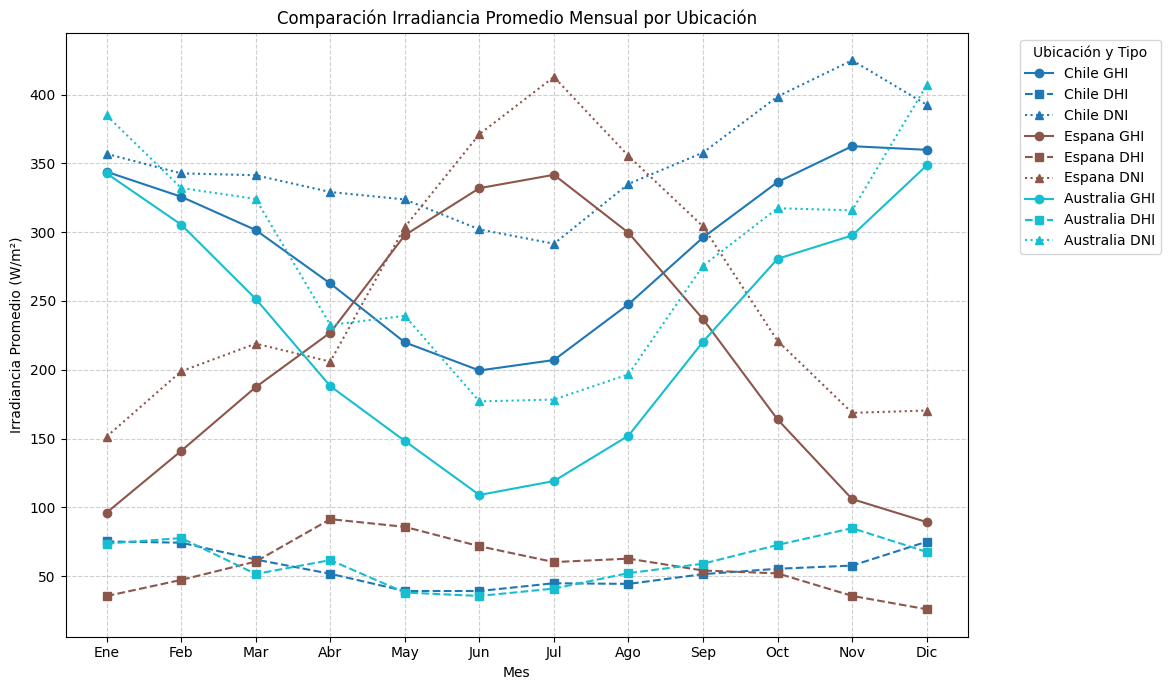

In [12]:
# ---------------- GRÁFICOS COMPARATIVOS DE IRRADIANCIA ----------------
if 'resultados_generales' in locals(): # Verificar si la variable existe
    # 2. Gráfico Combinado de Irradiancia Mensual Promedio
    plt.figure(figsize=(14, 7))
    meses_str = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    
    # Usar un mapa de colores si hay resultados
    num_paises = len(resultados_generales)
    if num_paises > 0:
        colores = plt.cm.get_cmap('tab10', num_paises) 
    else:
        colores = None # Evitar error si no hay países

    plot_legend_general_mensual = False
    for i, (pais, data) in enumerate(resultados_generales.items()):
        if 'mensual_df_polars' in data and isinstance(data['mensual_df_polars'], pl.DataFrame) and not data['mensual_df_polars'].is_empty():
            df_mensual_pl = data['mensual_df_polars']
            # Graficar GHI, DHI, DNI para este país
            if 'GHI_promedio' in df_mensual_pl.columns:
                plt.plot(meses_str, df_mensual_pl['GHI_promedio'], marker='o', linestyle='-', color=colores(i) if colores else 'blue', label=f'{pais} GHI')
                plot_legend_general_mensual = True
            if 'DHI_promedio' in df_mensual_pl.columns:
                plt.plot(meses_str, df_mensual_pl['DHI_promedio'], marker='s', linestyle='--', color=colores(i) if colores else 'green', label=f'{pais} DHI')
                plot_legend_general_mensual = True
            if 'DNI_promedio' in df_mensual_pl.columns:
                plt.plot(meses_str, df_mensual_pl['DNI_promedio'], marker='^', linestyle=':', color=colores(i) if colores else 'red', label=f'{pais} DNI')
                plot_legend_general_mensual = True
        else:
                print(f"  Advertencia: No hay datos mensuales válidos (o no es DataFrame Polars) para graficar en {pais}.")

    if plot_legend_general_mensual:
        plt.xlabel('Mes')
        plt.ylabel('Irradiancia Promedio (W/m²)')
        plt.title('Comparación Irradiancia Promedio Mensual por Ubicación')
        # Colocar la leyenda fuera del gráfico para evitar solapamientos
        plt.legend(title='Ubicación y Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para leyenda externa
        # Guardar y mostrar
        try:
            plt.savefig(os.path.join(resultados_dir_base, 'comparacion_irradiacion_mensual.png'))
            print("  Gráfico mensual combinado guardado.")
        except Exception as e:
            print(f"  Error al guardar gráfico mensual combinado: {e}")
        plt.show()
    else:
        print("No hay datos válidos para mostrar en el gráfico mensual combinado.")
    plt.close() # Cerrar la figura explícitamente
    # --- FIN PARTE 2 ---    
else:
    print("Variable 'resultados_generales' no definida. Ejecuta la celda anterior.")

---

### 📊 Distribución Anual de Velocidad del Viento

El primer gráfico boxplot muestra la distribución anual de la velocidad del viento en las tres ubicaciones.

- **Chile**: velocidad media moderada (~2.5 m/s), baja dispersión.
- **España**: perfil más bajo, con menor variabilidad y numerosos outliers por encima de 5 m/s.
- **Australia**: mayor mediana (~3.2 m/s) y amplia dispersión, alcanzando hasta 8 m/s.

> *Aunque no es una variable principal para tecnologías solares, la velocidad del viento puede influir en el comportamiento térmico de los módulos y en el ensuciamiento por polvo.*


### 🌡️ Distribución Anual de Temperatura Ambiente

El segundo boxplot muestra la variabilidad térmica anual:

- **Chile**: perfil estable (10–28 °C), ideal para eficiencia fotovoltaica.
- **España**: alta variabilidad térmica (−2 °C a 42 °C), lo que puede reducir la eficiencia estacional.
- **Australia**: temperaturas altas en verano, pero distribución más equilibrada que en España.

> *Temperaturas más elevadas disminuyen el rendimiento de los módulos FV. Chile presenta el perfil más favorable.*

---




/tmp/ipykernel_1712/27741113.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Pais', y='Temperature', data=df_completo_pd, palette='viridis')


  Boxplot de Temperatura guardado.


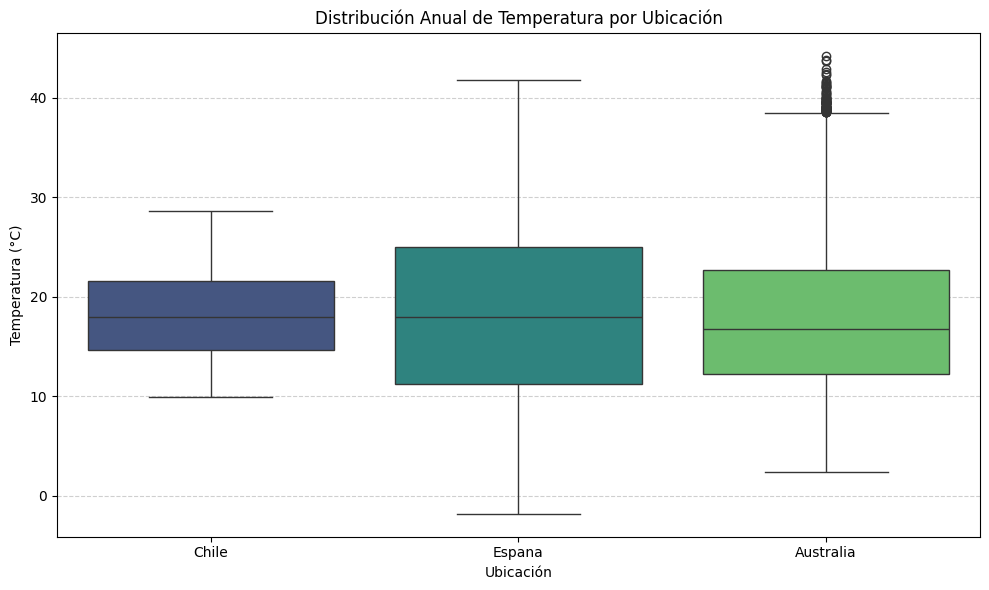

/tmp/ipykernel_1712/27741113.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Pais', y='Wind Speed', data=df_completo_pd, palette='plasma')


  Boxplot de Velocidad del Viento guardado.


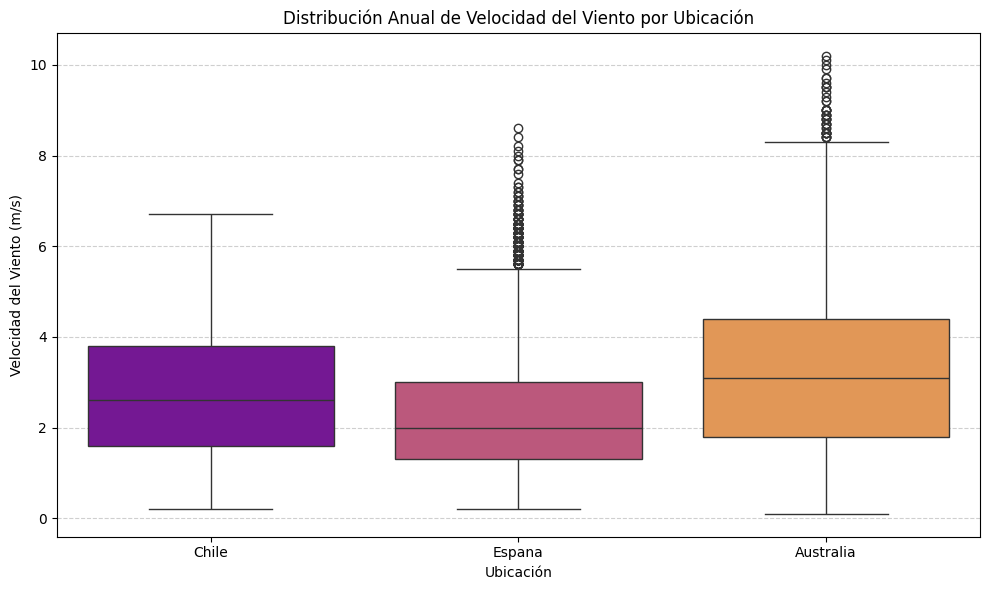


--- Fin del Resumen Comparativo ---


In [13]:
# ---------------- GRÁFICOS COMPARATIVOS DE TEMPERATURA Y VIENTO ----------------
if 'dataframes_por_ubicacion' in locals(): # Verificar si la variable existe
    # 3. Boxplots Comparativos (Temperatura y Viento)

    # Combinar DataFrames originales añadiendo columna 'Pais'
    lista_dfs_completos = []
    for pais, df_pl in dataframes_por_ubicacion.items():
        if df_pl is not None and isinstance(df_pl, pl.DataFrame) and not df_pl.is_empty():
                # Añadir columna 'Pais'
            df_con_pais = df_pl.with_columns(pl.lit(pais).alias("Pais"))
            # Seleccionar solo las columnas necesarias para los boxplots
            columnas_boxplot = ['Pais']
            if 'Temperature' in df_con_pais.columns:
                columnas_boxplot.append('Temperature')
            if 'Wind Speed' in df_con_pais.columns:
                columnas_boxplot.append('Wind Speed')

            if len(columnas_boxplot) > 1: # Asegurarse que hay datos para plotear
                df_seleccionado = df_con_pais.select(columnas_boxplot)
                lista_dfs_completos.append(df_seleccionado)
            else:
                print(f"  Advertencia: No se encontraron columnas 'Temperature' o 'Wind Speed' para {pais}, no se incluirá en boxplots.")

        else:
                print(f"  Advertencia: DataFrame vacío, None o tipo incorrecto para {pais}, no se incluirá en boxplots.")

    if lista_dfs_completos:
        df_completo_pl = pl.concat(lista_dfs_completos)
        # Convertir a Pandas para Seaborn
        df_completo_pd = df_completo_pl.to_pandas()

        # Boxplot Temperatura
        if 'Temperature' in df_completo_pd.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='Pais', y='Temperature', data=df_completo_pd, palette='viridis')
            plt.title('Distribución Anual de Temperatura por Ubicación')
            plt.ylabel('Temperatura (°C)')
            plt.xlabel('Ubicación')
            plt.grid(True, axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            # Guardar y mostrar
            try:
                plt.savefig(os.path.join(resultados_dir_base, 'comparacion_boxplot_temperatura.png'))
                print("  Boxplot de Temperatura guardado.")
            except Exception as e:
                print(f"  Error al guardar boxplot de temperatura: {e}")
            plt.show()
        else:
                print("  Advertencia: Columna 'Temperature' no encontrada para Boxplot.")
        plt.close() # Cerrar figura

        # Boxplot Wind Speed
        if 'Wind Speed' in df_completo_pd.columns:
                plt.figure(figsize=(10, 6))
                sns.boxplot(x='Pais', y='Wind Speed', data=df_completo_pd, palette='plasma')
                plt.title('Distribución Anual de Velocidad del Viento por Ubicación')
                plt.ylabel('Velocidad del Viento (m/s)')
                plt.xlabel('Ubicación')
                plt.grid(True, axis='y', linestyle='--', alpha=0.6)
                plt.tight_layout()
                # Guardar y mostrar
                try:
                    plt.savefig(os.path.join(resultados_dir_base, 'comparacion_boxplot_viento.png'))
                    print("  Boxplot de Velocidad del Viento guardado.")
                except Exception as e:
                    print(f"  Error al guardar boxplot de viento: {e}")
                plt.show()
        else:
                print("  Advertencia: Columna 'Wind Speed' no encontrada para Boxplot.")
        plt.close() # Cerrar figura

    else:
        print("No hay DataFrames válidos para generar los boxplots comparativos.")
    
    # 3. (Opcional) Guardar el DataFrame combinado si se necesita
    # if 'df_stats_final' in locals() and isinstance(df_stats_final, pd.DataFrame):
    #    try:
    #        stats_file_path = os.path.join(resultados_txt_dir, 'estadisticas_descriptivas_combinadas.csv')
    #        df_stats_final.to_csv(stats_file_path, index=False, float_format='%.2f')
    #        print(f"\nDataFrame combinado de estadísticas guardado en: {stats_file_path}")
    #    except Exception as e:
    #        print(f"\nError al guardar DataFrame combinado: {e}")

    print("\n--- Fin del Resumen Comparativo ---")
    # --- FIN PARTE 3 ---
else:
    print("Variable 'dataframes_por_ubicacion' no definida. Ejecuta la celda anterior.")
